In [1]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/labeled_training (2).csv')
df_dev = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H_2024_Task6_Dev.csv')

In [2]:
import re
import pandas as pd
def preprocess_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.lower()
    text = re.sub(r'[@#]\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df_train['text'] = df_train['text'].apply(preprocess_text)
df_dev['text'] = df_dev['text'].apply(preprocess_text)

In [3]:
!pip install transformers seqeval torch tqdm accelerate sentencepiece datasets

In [4]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy, TrainerCallback
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
import os
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
class SaveModelCallback(TrainerCallback):
    def __init__(self, output_dir):
        self.output_dir = output_dir
    def on_epoch_end(self, args, state, control, **kwargs):
        output_dir = os.path.join(self.output_dir, f"epoch_bartlarge_{state.epoch}")
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=2) # Adjust num_labels as per your requirement
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results_temp',
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy=IntervalStrategy.NO,
    save_strategy=IntervalStrategy.NO,
    load_best_model_at_end=False,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    callbacks=[SaveModelCallback(output_dir='./model_saves')]
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWar

Step,Training Loss
100,0.716500
200,0.642800
300,0.601500
400,0.668500
500,0.552200
600,0.515700
700,0.476000
800,0.475100
900,0.417300
1000,0.421300


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Step,Training Loss
100,0.716500
200,0.642800
300,0.601500
400,0.668500
500,0.552200
600,0.515700
700,0.476000
800,0.475100
900,0.417300
1000,0.421300


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=22000, training_loss=0.1441968258421085, metrics={'train_runtime': 4014.5757, 'train_samples_per_second': 21.92, 'train_steps_per_second': 5.48, 'total_flos': 2.4096016159776e+16, 'train_loss': 0.1441968258421085, 'epoch': 10.0})

In [5]:
df_train['label'].value_counts()

0    5966
1    2834
Name: label, dtype: int64

In [6]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

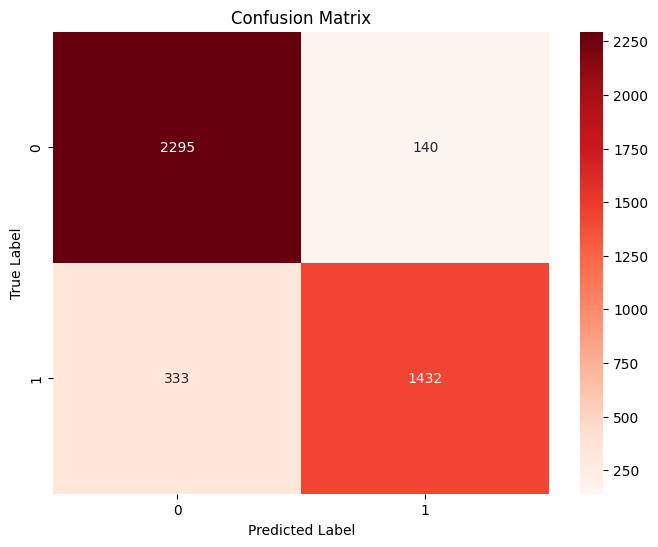

Accuracy: 0.8873809523809524
F1 Score (Class 1): 0.8582559184896614
Recall (Macro): 0.8769182891147164
Precision (Macro): 0.8921145735299244


In [7]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_1.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_1 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_1 = pd.concat([df_dev, df_predictions_1], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_1['label']                                                                                                   #THIS
predicted_labels = df_merged_1['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_1.to_csv('BartLarge_task6_predictions_001_epoch_1.csv', index=False)                                             #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

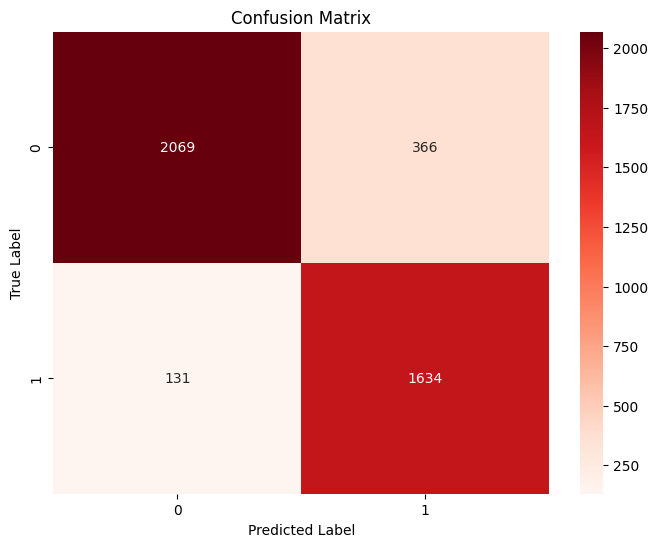

Accuracy: 0.8816666666666667
F1 Score (Class 1): 0.8679946879150067
Recall (Macro): 0.8877355143068215
Precision (Macro): 0.8787272727272727


In [8]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_2.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_2 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_2 = pd.concat([df_dev, df_predictions_2], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_2['label']                                                                                                   #THIS
predicted_labels = df_merged_2['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_2.to_csv('BartLarge_task6_predictions_001_epoch_2.csv', index=False)                                             #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

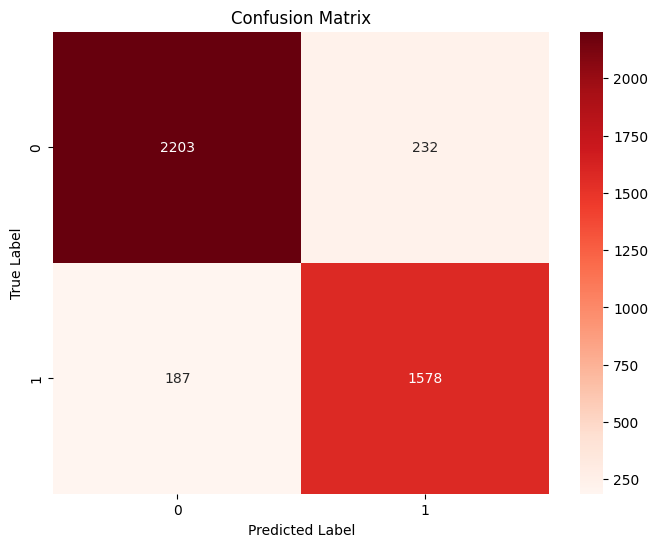

Accuracy: 0.9002380952380953
F1 Score (Class 1): 0.8827972027972028
Recall (Macro): 0.8993868920546096
Precision (Macro): 0.8967902632978109


In [9]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_3.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_3 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_3 = pd.concat([df_dev, df_predictions_3], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_3['label']                                                                                                   #THIS
predicted_labels = df_merged_3['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_3.to_csv('BartLarge_task6_predictions_001_epoch_3.csv', index=False)                                             #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

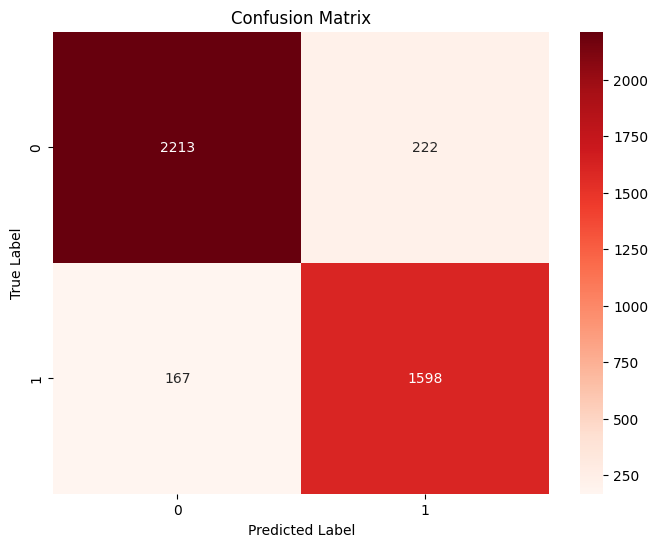

Accuracy: 0.9073809523809524
F1 Score (Class 1): 0.8914923291492329
Recall (Macro): 0.9071060025245621
Precision (Macro): 0.9039269553975436


In [10]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_4.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_4 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_4 = pd.concat([df_dev, df_predictions_4], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_4['label']                                                                                                   #THIS
predicted_labels = df_merged_4['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_4.to_csv('BartLarge_task6_predictions_001_epoch_4.csv', index=False)                                             #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

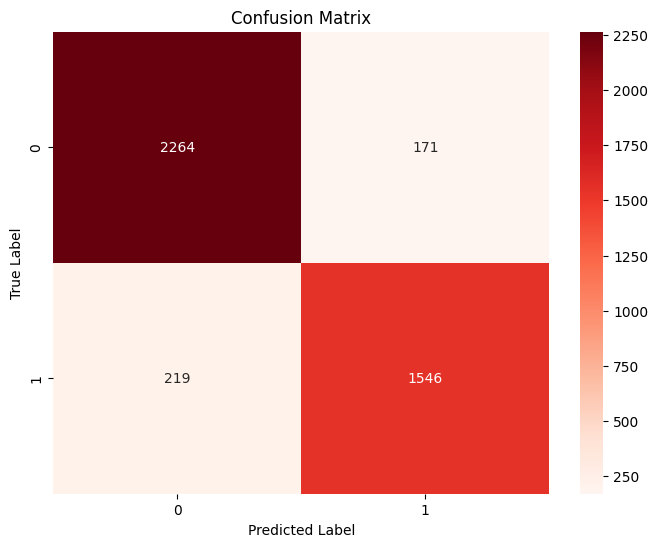

Accuracy: 0.9071428571428571
F1 Score (Class 1): 0.8879954049396898
Recall (Macro): 0.9028474035983736
Precision (Macro): 0.9061039647353899


In [11]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_5.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_5 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_5 = pd.concat([df_dev, df_predictions_5], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_5['label']                                                                                                   #THIS
predicted_labels = df_merged_5['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_5.to_csv('BartLarge_task6_predictions_001_epoch_5.csv', index=False)                                             #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

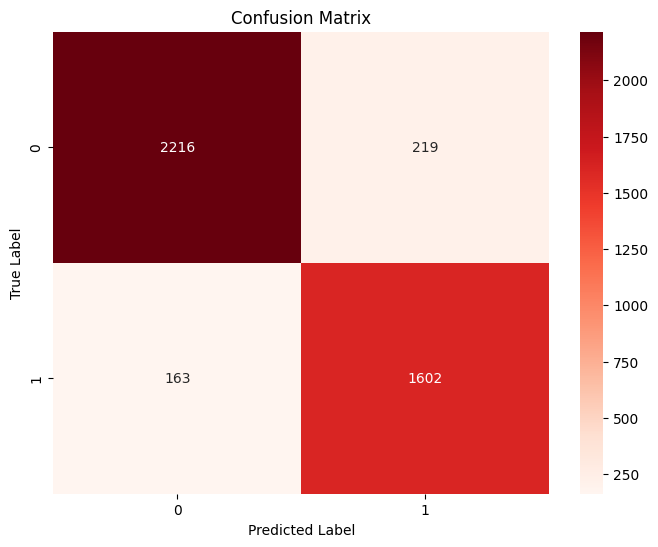

Accuracy: 0.909047619047619
F1 Score (Class 1): 0.8934746235359733
Recall (Macro): 0.9088551634275874
Precision (Macro): 0.9056101126482199


In [12]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_6.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_6 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_6 = pd.concat([df_dev, df_predictions_6], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_6['label']                                                                                                   #THIS
predicted_labels = df_merged_6['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_6.to_csv('BartLarge_task6_predictions_001_epoch_6.csv', index=False)                                             #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

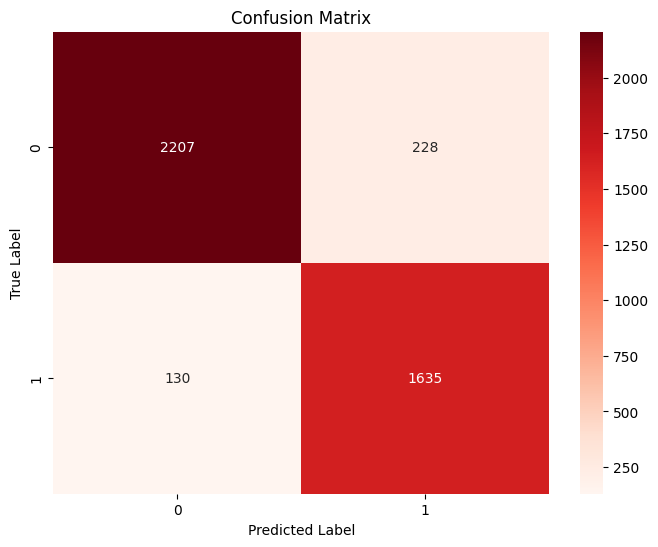

Accuracy: 0.9147619047619048
F1 Score (Class 1): 0.9013230429988974
Recall (Macro): 0.916355556072619
Precision (Macro): 0.9109949375618851


In [13]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_7.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_7 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_7 = pd.concat([df_dev, df_predictions_7], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_7['label']                                                                                                   #THIS
predicted_labels = df_merged_7['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_7.to_csv('BartLarge_task6_predictions_001_epoch_7.csv', index=False)                                             #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

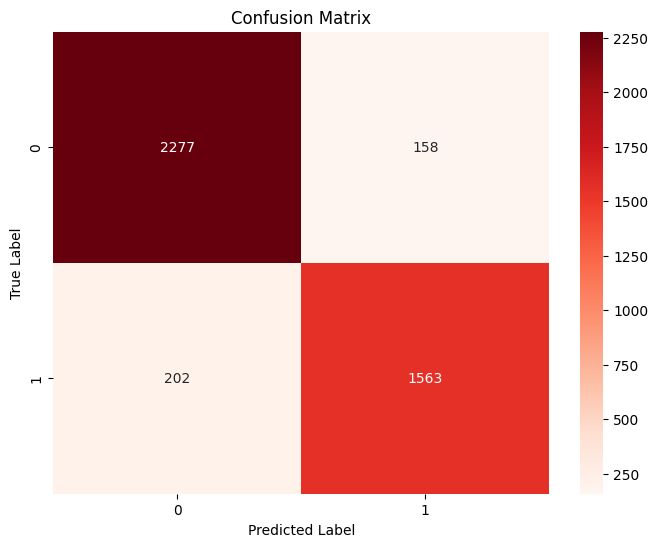

Accuracy: 0.9142857142857143
F1 Score (Class 1): 0.8967297762478484
Recall (Macro): 0.9103326721384902
Precision (Macro): 0.9133542207770139


In [14]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_8.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_8 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_8 = pd.concat([df_dev, df_predictions_8], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_8['label']                                                                                                   #THIS
predicted_labels = df_merged_8['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_8.to_csv('BartLarge_task6_predictions_001_epoch_8.csv', index=False)                                             #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

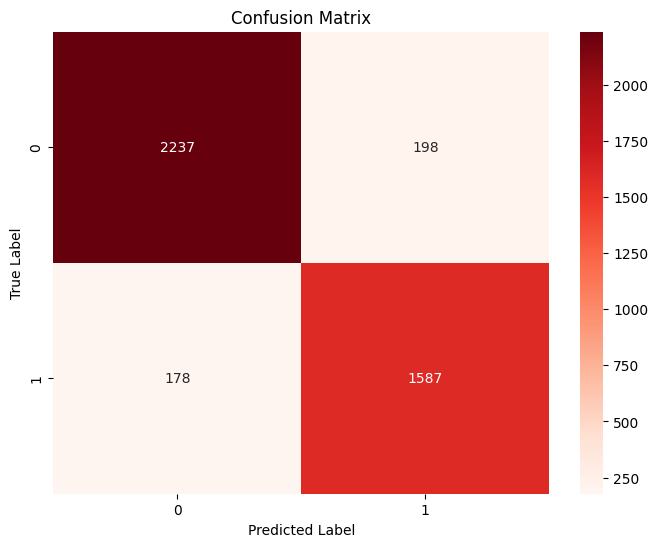

Accuracy: 0.9104761904761904
F1 Score (Class 1): 0.8940845070422535
Recall (Macro): 0.908917986632618
Precision (Macro): 0.907684813055657


In [15]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_9.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_9 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_9 = pd.concat([df_dev, df_predictions_9], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_9['label']                                                                                                   #THIS
predicted_labels = df_merged_9['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_9.to_csv('BartLarge_task6_predictions_001_epoch_9.csv', index=False)                                             #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

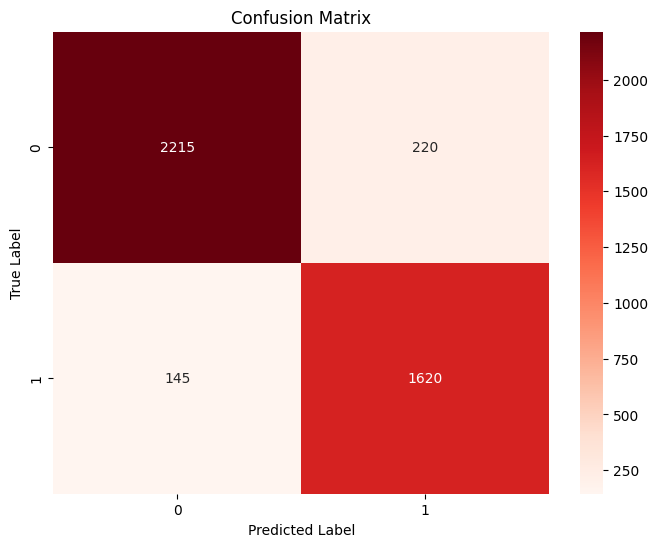

Accuracy: 0.9130952380952381
F1 Score (Class 1): 0.8987517337031901
Recall (Macro): 0.9137489747601957
Precision (Macro): 0.9094970523212971


In [16]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_10.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_10 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_10 = pd.concat([df_dev, df_predictions_10], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_10['label']                                                                                                   #THIS
predicted_labels = df_merged_10['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_10.to_csv('BartLarge_task6_predictions_001_epoch_10.csv', index=False)                                             #THIS

In [17]:
df_merged_1

,id,text,source,label,predicted_label,prediction_0_weight,prediction_1_weight
0,8801,everybody developa cataracts with age. disease...,reddit,0,0,0.998536,0.001464
1,8802,"i have not heard that before. i have icl's, bu...",reddit,0,0,0.996781,0.003219
2,8803,what does your doctor/fitter say? i sure wish ...,reddit,0,0,0.998092,0.001908
3,8804,dear doctor of optometrists of the internet i ...,reddit,1,1,0.011729,0.988271
4,8805,"if you have sharp vision without correction, p...",reddit,0,0,0.998522,0.001478
...,...,...,...,...,...,...,...
4195,12996,why cant people just accept no as an answer! -...,reddit,1,1,0.011069,0.988931
4196,12997,even the thought of this terrifies me. im 18 a...,reddit,1,1,0.004425,0.995575
4197,12998,i don't think exposure works for me either. i ...,reddit,0,0,0.998230,0.001770
4198,12999,i'm a 16 year old going into junior year of hi...,reddit,1,1,0.004402,0.995598
